# Overview
Steps to build the network:

1. Load the training data and do a train/validation split.
2. Preprocess data.
3. Build a convolutional neural network to classify traffic signs.
4. Build a feedforward neural network to classify traffic signs.
5. Evaluate performance of final neural network on testing data.

Keep an eye on the network’s accuracy over time. Once the accuracy reaches the 98% range, you can be confident that you’ve built and trained an effective model.

In [1]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import math

from keras.models import Sequential
from keras.layers import Dense, Activation
import cv2

import json
import random

Using TensorFlow backend.


Load the Data

In [2]:
# Load the data by reading the logfile

data = pd.read_csv('data/data/driving_log.csv',dtype={'center': str, 'left':str,'right':str,
                                                      'steering': np.float32,'throttle': np.float32,
                                                      'brake': np.float32,'speed': np.float32},
                   skipinitialspace=1)
                   #converters={'category',"Price":int} dtype='category')
print(data.dtypes)

X_train = data['center']
y_train = data['steering']

center = data['center']
left = data['left']
right = data['right']
steering = data['steering']
throttle = data['throttle']
speed=data['speed']
brake=data['brake']
print('Training data size = ', len(X_train))
print('Training labels size = ',len(y_train))
print('Training throttle size = ',len(throttle))
print('Training speed size = ',len(speed))

print('Data loaded')

center       object
left         object
right        object
steering    float32
throttle    float32
brake       float32
speed       float32
dtype: object
Training data size =  8036
Training labels size =  8036
Training throttle size =  8036
Training speed size =  8036
Data loaded


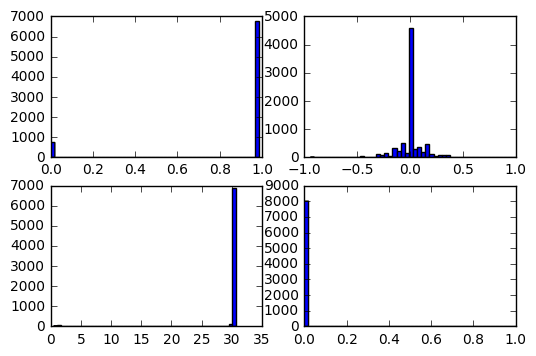

1.0
0.985533


In [3]:
# examine the data
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(2,2,1)
plt.hist(throttle,50)
ax = fig.add_subplot(2,2,2)
plt.hist(steering,50)
ax = fig.add_subplot(2,2,3)
plt.hist(speed,50)
ax = fig.add_subplot(2,2,4)
plt.hist(brake,50)
plt.show()
print(max(brake))
print(max(throttle))

In [4]:
def shift_and_crop (filename,steering,direction):
    img = cv2.imread(filename)
    rows,cols,channels = img.shape
    if direction == 'l' or direction == 'left':
        M = np.float32([[1,0,-10],[0,1,0]]) # REMEMBER TO ADD 0.1 TO STEERING
        dst = cv2.warpAffine(img,M,(cols,rows))
        crop_img = crop_image(dst)
        steering = steering-0.1
    else:
        M = np.float32([[1,0,10],[0,1,0]]) # REMEMBER TO ADD -0.1 TO STEERING
        dst = cv2.warpAffine(img,M,(cols,rows))
        crop_img = crop_image(dst)
        steering = steering+0.1
    
    return crop_img, steering

def crop_image(dst): 
    crop_img = dst[60:140, 10:310] # original size 320 x 160, final size 300 x 80crop_img
    return crop_img

print('crop_images function defined')

crop_images function defined


In [5]:
# augment data by:
# 1) using all images, center, left and righ 
#     a) crop all images to relevant section (remove car and sky) 
# 2) duplicate and flip images (invert steering)
#     a) crop
# 3) shift images to left and right 
# of all above just save those which fall under the desired probability

import random

random.seed()
count = 0

print('Saving augmented images. Please wait...')

for i in range(len(center)):
#for i in range(10):
    # 1) using all images, center, left and righ
    new_images = []
    new_steering = []
#     a) crop all images to relevant section (remove car and sky) 

    filename = 'data/data/'+center[i]
    new_steering.append (steering[i])
    img = cv2.imread(filename)
    crop_img = crop_image(img)
    new_images.append(crop_img)
    
    new_img, new_st = shift_and_crop (filename,steering[i],'left')
    new_images.append(new_img)
    new_steering.append(new_st)
    
    new_img, new_st = shift_and_crop (filename,steering[i],'right')
    new_images.append(new_img)
    new_steering.append(new_st)
    
    filename = 'data/data/'+left[i]
    new_steering.append(steering[i]+0.1)
    img = cv2.imread(filename)
    crop_img = crop_image(img)
    new_images.append(crop_img)
    
    new_img, new_st = shift_and_crop (filename,steering[i]+0.1,'left')
    new_images.append(new_img)
    new_steering.append(new_st)
    
    new_img, new_st = shift_and_crop (filename,steering[i]+0.1,'right')
    new_images.append(new_img)
    new_steering.append(new_st)
    
    filename = 'data/data/'+right[i]
    new_steering.append(steering[i]-0.1)
    img = cv2.imread(filename)
    crop_img = crop_image(img)
    new_images.append(crop_img)
    
    new_img, new_st = shift_and_crop (filename,steering[i]-0.1,'left')
    new_images.append(new_img)
    new_steering.append(new_st)
    
    new_img, new_st = shift_and_crop (filename,steering[i]-0.1,'right')
    new_images.append(new_img)
    new_steering.append(new_st)
    assert (len(new_images)==9)
    
    for j in range(len(new_images)):
        # add flipped images
        new_images.append(cv2.flip(new_images[j],1))
        new_steering.append((new_steering[j])*(-1))

    assert (len(new_images)==18)
    
    # save according to the probability
    # higher steering have higher probability of being saved
    logfile = open('./data/new_data/new_log.csv','a')
    for j in range(len(new_images)):
        rand_num = random.random()
        #print(rand_num,',',abs(new_steering[j]))
        if abs(new_steering[j])>=rand_num:
            #save this image to the final set    
            filename = 'IMG/image_'+str(count)+'.jpg'
            count = count+1
            cv2.imwrite('data/new_data/'+filename,new_images[j])
            logfile.write(filename+','+str(new_steering[j])+'\n')

    logfile.close()

print('Data saved')

Saving augmented images. Please wait...
Data saved


In [32]:
# read new images

data = pd.read_csv('data/new_data/new_log.csv',
                   dtype={'center': str,'steering': np.float32},
                   skipinitialspace=1)
print(data.dtypes)

X_train = data['center']
y_train = data['steering']

print('Training data size = ', len(X_train))
print('Training labels size = ',len(y_train))

print('Data loaded')


center       object
steering    float32
dtype: object
Training data size =  18661
Training labels size =  18661
Data loaded


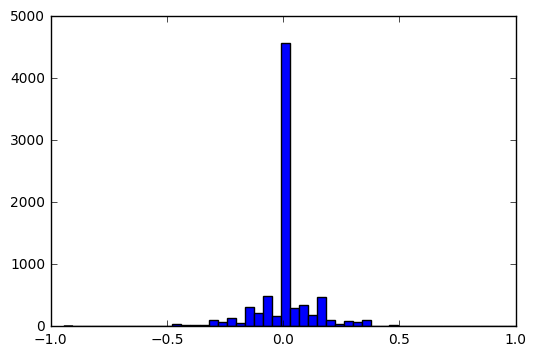

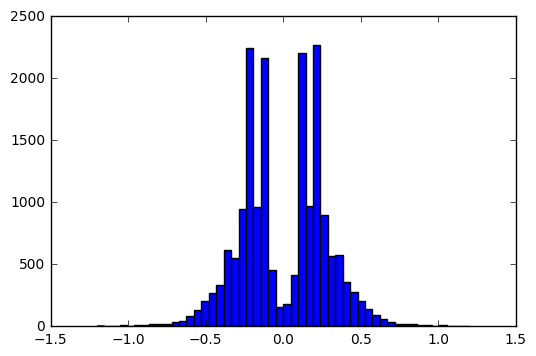

In [33]:
# examine the data
import matplotlib.pyplot as plt
plt.hist(steering,50)
plt.show()
plt.hist(y_train,50)
plt.show()

[0.0, -0.10000000000000001, 0.10000000000000001, 0.10000000000000001, 0.0, 0.20000000000000001, -0.10000000000000001, -0.20000000000000001, 0.0, -0.0, 0.10000000000000001, -0.10000000000000001, -0.10000000000000001, -0.0, -0.20000000000000001, 0.10000000000000001, 0.20000000000000001, -0.0]


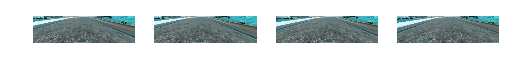

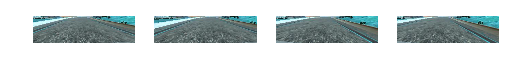

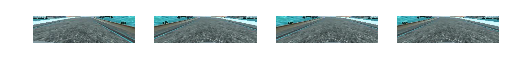

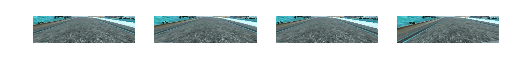

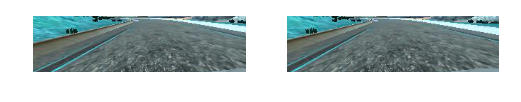

In [21]:
#display images side by side
def plotImageSet(image_list,color='gnuplot2'):
    fig = plt.figure()
    count = 1
    for image in image_list:
        ax = fig.add_subplot(1,len(image_list),count)
        imgplot = plt.imshow(image,cmap=color)
        ax.axis('off')
        count = count +1
    plt.show()
    
print(new_steering)
plotImageSet(new_images[0:4])
plotImageSet(new_images[4:8])
plotImageSet(new_images[8:12])
plotImageSet(new_images[12:16])
plotImageSet(new_images[16:18])

In [22]:
img=cv2.imread('data/data/'+left[0])



In [44]:

# After briefly examining the data I decided to:
# Remove data when steering equals 0
# Remove data when throttle < 0.1 
# Remove data when speed < 25
# Remove data when brake > 0
X_removed = []
y_removed = []
X_remaining = []
y_remaining = []
for i in range(len(X_train)):
    if throttle[i] < 0.5 or speed[i] < 25 or brake[i] > 0 or (steering[i]>-0.01 and steering[i]<0.01):
        X_removed.append(X_train[i])
        y_removed.append(y_train[i])
    else:
        X_remaining.append(X_train[i])
        y_remaining.append(y_train[i])
X_train = X_remaining
y_train = y_remaining
#print('Removed all values with steering = 0.0')
print('Data filtered according to definitions')

Data filtered according to definitions


# there are a lot of images corresponding to the zero value
# we can remove most of them
# 1) copy those values to the zero_values array
# 2) copy the non zero values to the train_crop array
# 3) add just a few random zero values to the final array
X_removed = []
y_removed = []
X_remaining = []
y_remaining = []
for i in range(len(X_train)):
    if y_train[i] == 0:
        X_removed.append(X_train[i])
        y_removed.append(y_train[i])
    else:
        X_remaining.append(X_train[i])
        y_remaining.append(y_train[i])
X_train = X_remaining
y_train = y_remaining
print('Removed all values with steering = 0.0')

Number of elements removed: 4777
Number of elements removed: 4777
Number of elements remaining: 3259
Number of elements remaining: 3259


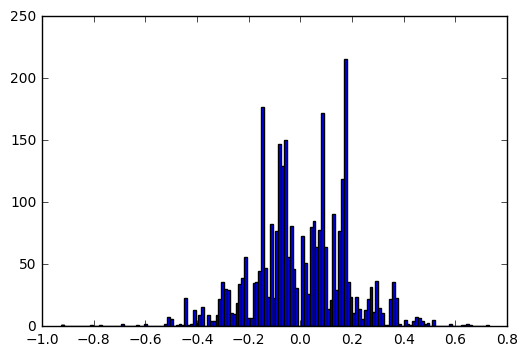

In [45]:
def print_num_el():
    print ('Number of elements removed:',len(X_removed))
    print ('Number of elements removed:',len(y_removed))
    print ('Number of elements remaining:',len(X_train))
    print ('Number of elements remaining:',len(y_train))
print_num_el()
plt.hist(y_train,150)
plt.show()

Higher steering values are very scarce so we need to augment the density of those values in our training set.
In order to do so without interfering with the data directly (e.g. by introducing shifts and artificial rotations, flips, etc) we will just add more of those elements with higher steering by duplicating them.

IMG/image_0.jpg


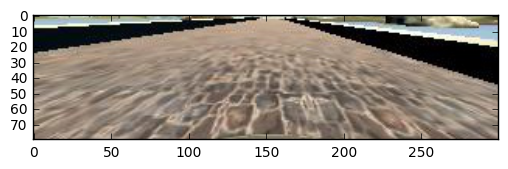

0.0402428


In [34]:
# visualise some data
iter = 200
from PIL import Image
print(X_train[0])
image = Image.open('./data/new_data/' + X_train[iter])
image_array = np.asarray(image)
plt.imshow(image)
plt.show()
print (y_train[iter])


Steering: 0.176582


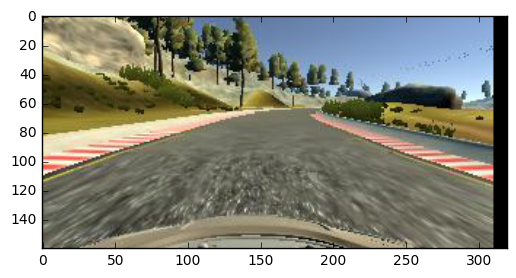

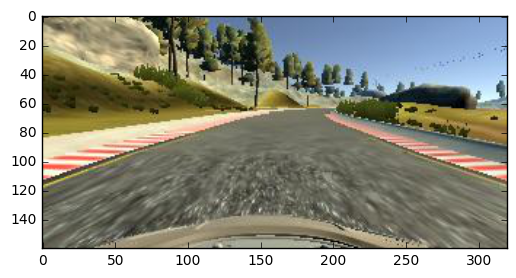

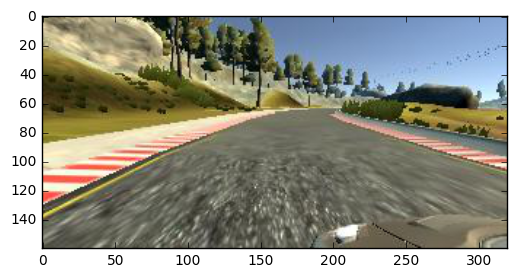

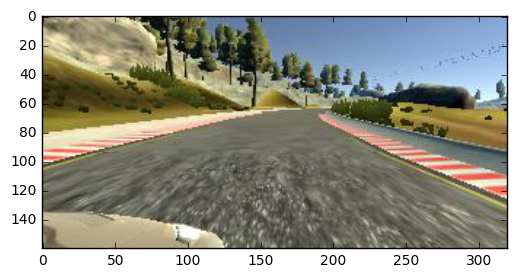

In [51]:
iter = 1128
print('Steering:',y_train[iter])
import cv2
import numpy as np
img_center = cv2.imread('./data/data/' + X_train[iter])
img_left = cv2.imread('./data/data/' + left[iter])
img_right = cv2.imread('./data/data/' + right[iter])
img_steering = steering[iter]
img_throttle = throttle[iter]
img_speed = speed[iter]
img_brake = brake[iter]

rows,cols,channels = img_center.shape
M = np.float32([[1,0,-10],[0,1,0]]) # REMEMBER TO ADD 0.1 TO STEERING
#M = np.float32([[1,0,10],[0,1,0]]) # REMEMBER TO ADD -0.1 TO STEERING
dst = cv2.warpAffine(img_center,M,(cols,rows))
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(img_center, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB))
plt.show()
img = cv2.imwrite('./data/data_aug/' + center[iter], img_center)
img = cv2.imwrite('./data/data_aug/' + left[iter], img_left)
img = cv2.imwrite('./data/data_aug/' + right[iter], img_right)

#append to log filenames and new steering

In [ ]:
# flip images and steering to augment data

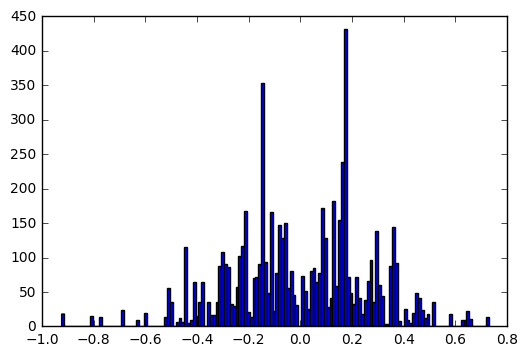

In [15]:
X_train_aug = list(X_train)
y_train_aug = list(y_train)
for i in range(len(y_train)):
    if abs(y_train[i]) > 0.1:
        X_train_aug.append(X_train[i])
        y_train_aug.append(y_train[i])
    if abs(y_train[i]) > 0.2:
        X_train_aug.append(X_train[i])
        y_train_aug.append(y_train[i])
    if abs(y_train[i]) > 0.3:
        X_train_aug.append(X_train[i])
        y_train_aug.append(y_train[i])
    if abs(y_train[i]) > 0.4:
        X_train_aug.append(X_train[i])
        y_train_aug.append(y_train[i])
    if abs(y_train[i]) > 0.45:
        X_train_aug.append(X_train[i])
        y_train_aug.append(y_train[i])
    if abs(y_train[i]) > 0.5:
        X_train_aug.append(X_train[i])
        y_train_aug.append(y_train[i])
    if abs(y_train[i]) > 0.54:
        X_train_aug.append(X_train[i])
        y_train_aug.append(y_train[i])
    if abs(y_train[i]) > 0.56:
        X_train_aug.append(X_train[i])
        y_train_aug.append(y_train[i])
    if abs(y_train[i]) > 0.60:
        X_train_aug.append(X_train[i])
        y_train_aug.append(y_train[i])
    if abs(y_train[i]) > 0.64:
        X_train_aug.append(X_train[i])
        y_train_aug.append(y_train[i])
    if abs(y_train[i]) > 0.68:
        X_train_aug.append(X_train[i])
        y_train_aug.append(y_train[i])
    if abs(y_train[i]) > 0.72:
        X_train_aug.append(X_train[i])
        y_train_aug.append(y_train[i])
    if abs(y_train[i]) > 0.76:
        X_train_aug.append(X_train[i])
        y_train_aug.append(y_train[i])
    if abs(y_train[i]) > 0.80:
        X_train_aug.append(X_train[i])
        y_train_aug.append(y_train[i])
    if abs(y_train[i]) > 0.84:
        X_train_aug.append(X_train[i])
        y_train_aug.append(y_train[i])
    if abs(y_train[i]) > 0.88:
        X_train_aug.append(X_train[i])
        y_train_aug.append(y_train[i])
    if abs(y_train[i]) > 0.92:
        X_train_aug.append(X_train[i])
        y_train_aug.append(y_train[i])
    
plt.hist(y_train_aug, 150)
plt.show()


In [17]:
X_remaining = X_train_aug
y_remaining = y_train_aug

# there are still a lot of images between -0.2 and 0.2
# we can remove most of them
# 1) copy those values to the zero_values array
# 2) copy the non zero values to the train_crop array
# 3) add just a few random zero values to the final array
X_removed = []
y_removed = []
X_remaining = []
y_remaining = []
for i in range(len(X_train_aug)):
    if y_train_aug[i] > -0.3 and y_train_aug[i] < 0.3:
        X_removed.append(X_train_aug[i])
        y_removed.append(y_train_aug[i])
    else:
        X_remaining.append(X_train_aug[i])
        y_remaining.append(y_train_aug[i])
print('Removed all values with steering between -0.2 and 0.2')

print ('Removed:',len(y_removed))
print ('Remaining:',len(y_remaining))

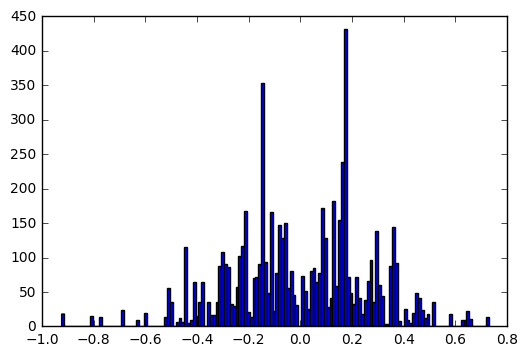

In [19]:
# examine data again
plt.hist(y_remaining,150)
plt.show()

#add some random values back
import random
batch_size = 100
index = np.random.choice(len(y_removed), size=batch_size, replace=False)

for i in index:
    X_remaining.append(X_removed[i])
    y_remaining.append(y_removed[i])
print('Added back some values with steering between -0.2 and 0.2')

# examine data again
plt.hist(y_remaining,150)
plt.show()

# preprocess all data and save to pickle files
from PIL import Image
import pickle
    
def normalise(im):
    width,height = im.size
    im = np.array(im.resize((round(width*0.5),round(height*0.5)), Image.ANTIALIAS)) # reduce to half size
    im = im/255 - 0.5 # normalise data
    return im
        
def append_pickle (pickle_filename, data):
    with open(pickle_filename,'ab') as wfp:
        pickle.dump(data, wfp)

def process_images (data, pickle_filename):
    X_train_im = []
    for filename in data:
        #print('data/data/'+filename)
        im = Image.open('data/data/'+filename)
        #plt.imshow(im);
        #plt.show()
        im = normalise(im)
        X_train_im.append(im)
    return X_train_im
        #append_pickle(pickle_filename, im)
    #print('Data saved to pickle file:',pickle_filename)
    
def process_labels (data, pickle_filename):
    append_pickle(pickle_filename, data)
    print('Data saved to pickle file:',pickle_filename)

X_train_im = process_images (X_train_crop2,'data.p') # note: here images are saved one by one
#process_labels (y_train[1:6],'labels.p') # note: labels are saved all in one go
print ('Images processed and stored in array')

from numpy import *
print(type(X_train_im))
X_train_im = np.array(X_train_im)
X_train_im =X_train_im.astype(float32)
print(type(X_train_im))
print(type(y_train_crop))
y_train_crop2 = np.array(y_train_crop2)
y_train_crop2 = y_train_crop2.astype(float32)
print(type(y_train_crop))

#save data to pickle files
pickle_filename = 'data.p'
with open(pickle_filename,'wb') as wfp:
    pickle.dump(X_train_im, wfp)
print('data saved to pickle file')
pickle_filename = 'labels.p'
with open(pickle_filename,'wb') as wfp:
    pickle.dump(y_train_crop2, wfp)
print('labels saved to pickle file')

import pickle
# read data from pickle files

with open('data.p','rb') as rfp:
    data = pickle.load(rfp)
y_train = []
with open('labels.p','rb') as rfp:
    labels = pickle.load(rfp)
print(len(data))
print(len(labels))

In [20]:
data = X_remaining
labels = y_remaining
print(len(X_remaining))
print(len(y_remaining))

6513
6513


In [36]:
data = list(X_train)
labels = list(y_train)
print(len(X_train))
print(len(y_train))

18661
18661


In [37]:
from sklearn.model_selection import train_test_split

# split data into train, validate and test data
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.3,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.2,random_state=42)
#print(X_train.shape[0])
print('Data splitted into train, validation anda test data')
print('Training data size = ', len(X_train))
print('Training labels size = ',len(y_train))
print('Validation data size = ',len(X_val))
print('Validation labels size = ',len(y_val))
print('Test data size = ',len(X_test))
print('Test labels size = ',len(y_test))

Data splitted into train, validation anda test data
Training data size =  13062
Training labels size =  13062
Validation data size =  4479
Validation labels size =  4479
Test data size =  1120
Test labels size =  1120


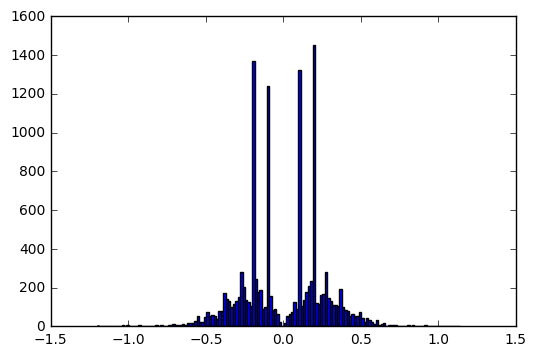

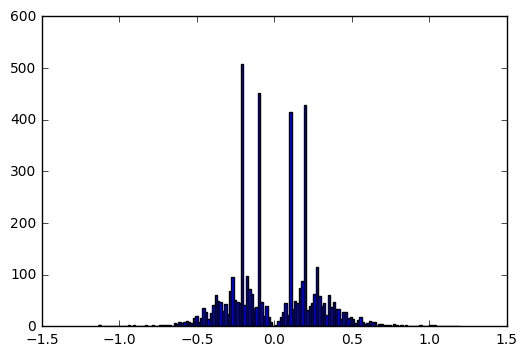

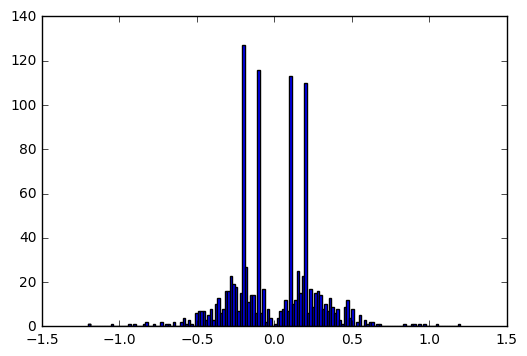

In [38]:
plt.hist(y_train,150)
plt.show()
plt.hist(y_val,150)
plt.show()
plt.hist(y_test,150)
plt.show()

In [51]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Lambda
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
# define the model
#print('Input shape:',(X_train[0].shape))
#height,width,depth = X_train[0].shape[0],X_train[0].shape[1],X_train[0].shape[2]
#print('Input size:',height,',',width,',',depth)
#subsample=strides
model = Sequential()
model.add(Lambda(lambda x: x/255 - 0.5, input_shape=(80, 300, 3),output_shape=(80, 300, 3)))
model.add(Conv2D(24, 5, 5,subsample=(2, 2),W_regularizer='l2',dim_ordering='tf'))
#model.add(BatchNormalization()) #normalisation should be done before activation
model.add(Activation('relu'))
model.add(Conv2D(36, 5, 5,subsample=(2, 2),W_regularizer='l2',dim_ordering='tf'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(48, 5, 5,subsample=(2, 2),W_regularizer='l2',dim_ordering='tf'))

model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Conv2D(64, 3, 3,subsample=(1, 1),W_regularizer='l2',dim_ordering='tf'))

model.add(Activation('relu'))
model.add(Conv2D(64, 3, 3,subsample=(1, 1),W_regularizer='l2',dim_ordering='tf'))

model.add(Activation('relu'))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(100, name='fc1'))
model.add(BatchNormalization(mode=1))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(50, name='fc2'))
model.add(BatchNormalization(mode=1))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(10, name='fc3'))
model.add(BatchNormalization(mode=1))
model.add(Activation('relu'))
model.add(Dense(1,name='output'))

# other layers we may add
#model.add(MaxPooling2D((2,2)))

#Normalize the activations of the previous layer at each batch, i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.
#keras.layers.normalization.BatchNormalization(epsilon=0.001, mode=0, axis=-1, momentum=0.99, weights=None, beta_init='zero', gamma_init='one', gamma_regularizer=None, beta_regularizer=None)

# for a mean squared error regression problem
model.compile(optimizer=Adam(lr=0.0001),loss='mean_squared_error')
#model.compile(optimizer='rmsprop',loss='mse')
model.summary()
print('Model defined')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_5 (Lambda)                (None, 80, 300, 3)    0           lambda_input_5[0][0]             
____________________________________________________________________________________________________
convolution2d_21 (Convolution2D) (None, 38, 148, 24)   1824        lambda_5[0][0]                   
____________________________________________________________________________________________________
activation_33 (Activation)       (None, 38, 148, 24)   0           convolution2d_21[0][0]           
____________________________________________________________________________________________________
convolution2d_22 (Convolution2D) (None, 17, 72, 36)    21636       activation_33[0][0]              
___________________________________________________________________________________________

def next_batch(first_array, second_array, batch_size):
    index = np.random.choice(len(first_array), size=batch_size, replace=False)
    result_x = []
    result_y = []
    for id in index:
        result_x.append(first_array[id])
        result_y.append(second_array[id])
    return result_x, result_y

print('next_batch defined as a data generator')

def next_batch_val(first_array, second_array, batch_size):
    index = np.random.choice(len(first_array), size=batch_size, replace=False)
    result_x = []
    result_y = []
    for id in index:
        result_x.append(first_array[id])
        result_y.append(second_array[id])
    #result = (result_x, result_y)
    #yield result_x, result_y
    yield result_x, result_y

print('next_batch_val defined as a data generator')

In [52]:
from PIL import Image
    
def generator(X, Y):
    while 1:
        #X_sh = []
        #Y_sh = []
        #index_shuf = list(range(len(Y)))
        #random.shuffle(index_shuf)
        #for i in index_shuf:
        #   X_sh.append(X[i])
        #   Y_sh.append(Y[i])
        #for (x, y) in zip(X_sh, Y_sh):
        for (x, y) in zip(X, Y):
            path, angle = (x, y)
            angle = np.reshape(angle, [1])
            image = Image.open('./data/new_data/' + path)
            image_array = np.asarray(image)
            transformed_image_array = image_array[None, :, :, :]
            #image = cv2.imread('./data/data/' + path)
            #image = np.reshape(image, (1, 160, 320, 3))
            yield transformed_image_array, angle

IMG/image_2010.jpg


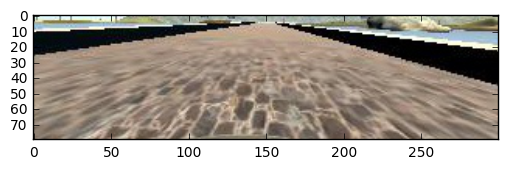

In [53]:
print(X_train[0])
#image = cv2.imread('./data/data/' + X_train[0])
image = Image.open('./data/new_data/' + X_train[0])
image_array = np.asarray(image)
plt.imshow(image)
plt.show()

In [54]:
print(len(X_train))
print(len(y_train))

13062
13062


In [55]:
#train the model
from keras.callbacks import ModelCheckpoint
print('')
iterations = 50
train_batch_size = 100#len(y_val) # len(X_train)
val_batch_size = 100#len(y_val)   # len(y_val)  #1928 
# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, verbose=1, monitor = 'val_loss', save_best_only=True, mode='min')
callbacks_list = [checkpoint]
history = model.fit_generator(generator(X_train, y_train), 
                    samples_per_epoch= train_batch_size,
                    nb_epoch=iterations,
                    callbacks=callbacks_list,
                    verbose=1,
                    validation_data=generator(X_val, y_val),
                    nb_val_samples=val_batch_size)
#history = model.fit(X_train, y_train, batch_size=train_batch_size, nb_epoch=iterations, callbacks=callbacks_list, verbose=1, validation_data=(X_val, y_val))
#history = model.fit_generator(next_batch(X_train,y_train,train_batch_size), samples_per_epoch=5000, nb_epoch=iterations,
  #                 verbose=1, validation_data=next_batch_val(X_val,y_val,val_batch_size), nb_val_samples=1000)
print('----------------- Model trained! -----------------')


Epoch 1/50
100/100 [==============================] - 5s - loss: 0.3172 - val_loss: 0.0968
Epoch 2/50
100/100 [==============================] - 3s - loss: 0.2693 - val_loss: 0.0829
Epoch 3/50
100/100 [==============================] - 3s - loss: 0.2777 - val_loss: 0.0512
Epoch 4/50
100/100 [==============================] - 3s - loss: 0.2428 - val_loss: 0.0644
Epoch 5/50
100/100 [==============================] - 3s - loss: 0.2237 - val_loss: 0.0763
Epoch 6/50
100/100 [==============================] - 3s - loss: 0.2200 - val_loss: 0.0472
Epoch 7/50
100/100 [==============================] - 3s - loss: 0.1946 - val_loss: 0.0313
Epoch 8/50
100/100 [==============================] - 3s - loss: 0.1702 - val_loss: 0.0323
Epoch 9/50
100/100 [==============================] - 3s - loss: 0.1708 - val_loss: 0.0436
Epoch 10/50
100/100 [==============================] - 3s - loss: 0.1718 - val_loss: 0.0369
Epoch 11/50
100/100 [==============================] - 3s - loss: 0.1404 - val_loss: 0.0

In [56]:
# evaluate the model
scores = model.evaluate_generator(generator(X_test, y_test),len(X_test))
print(scores)

0.0239868544085


In [57]:
from keras.models import model_from_json
import json

# convert model to json format
json_string = model.to_json()
with open('model.json', 'w') as outfile:
    json.dump(json_string, outfile)

#save model to files
model.save_weights('model.h5')

print('Model saved to file.')

Model saved to file.


In [ ]:
from keras.models import load_model
# returns a compiled model
# identical to the previous one
model = load_model('model.h5')